# Ensemble Learning

## 1. Learning with ensembles

In [6]:
from scipy.special import comb
import math
def ensemble_error(n_classifier,error):
    k_start = math.ceil(n_classifier/2)
    probs = [comb(n_classifier,k)* error ** k *(1-error)**(n_classifier - k) for k in range(k_start,n_classifier + 1)]
    return sum(probs)
ensemble_error(11,0.25)

0.03432750701904297

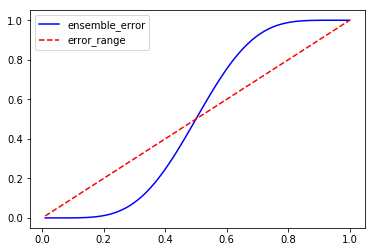

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
error_range = np.arange(0.01,1.01,0.01)

ens_error = [ensemble_error(11,i) for i in error_range]

plt.plot(error_range,ens_error,color = 'blue',label = "ensemble_error")
plt.plot(error_range,error_range,linestyle = '--',color = 'red',label = "error_range")
plt.legend(loc = 'upper left')

## 2. Majority Vote

In [13]:
import numpy as np
np.argmax(np.bincount([0,0,1],weights=[0.2,0.2,0.6]))

1

In [16]:
ex = np.array([[0.9,0.1],[0.8,0.2],[0.4,0.6]])
p = np.average(ex,axis = 0,weights=[0.2,0.2,0.6])
print(p)
print(np.argmax(p))

[0.58 0.42]
0


In [17]:
from sklearn.base import BaseEstimator # Base class for all estimators in scikit-learn
from sklearn.base import ClassifierMixin # Mixin class for all classifiers in scikit-learn.
from sklearn.preprocessing import LabelEncoder 
from sklearn.externals import six # Six provides simple utilities for wrapping over differences between Python 2 and Python 3
from sklearn.base import clone # Clone does a deep copy of the model in an estimator
from sklearn.pipeline import _name_estimators
import numpy as np
import operator


In [27]:
class MajorityVoteClassifier(BaseEstimator,ClassifierMixin):
    def __init__(self,classifiers,vote = 'classlabel',weights = None):
        self.classifiers = classifiers
        self.named_classifiers = {key:value for key,value in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights
    def fit(self,X,y):
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X,self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self
    def predict(self,X):
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X),axis = 1)
        else:
            predictions = np.asarray([clf.predict(X) for clf in self.classifiers_]).T
            maj_vote = np.apply_along_axis(lambda x:np.argmax(np.bincount(x,weights=self.weights)),axis = 1,arr = predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote
    def predict_proba(self,X):
        probas = np.asarray([clf.predict_proba(X) for clf in self.classifiers_])
        avg_proba = np.average(probas,axis = 0, weights=self.weights)
        return avg_proba
    def get_params(self,deep = True):
        if not deep:
            return super(MajorityVoteClassifier,self).get_params(deep = False)
        else:
            out = self.named_classifiers.copy()
            for name,step in six.iteritems(self.named_classifiers):
                for key,value in six.iteritems(step.get_params(deep = True)):
                    out['%s__%s'%(name,key)] = value
            return out
        

In [30]:
# Data Preprocessing
from sklearn import datasets
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder
iris = datasets.load_iris()
X,y = iris.data[50:,[1,2]],iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.5,random_state = 1)

## 3. Combining different algorithms with majority vote

In [23]:
# 3 different classifiers: LR,DT,KNN
# 10-fold-cross-validation
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score
import numpy as np
clf1 = LogisticRegression(penalty = 'l2',C = 0.001, random_state = 0)
clf2 = DecisionTreeClassifier(max_depth = 1,criterion = 'entropy',random_state = 0)
clf3 = KNeighborsClassifier(n_neighbors = 1,p = 2,metric = 'minkowski')
pipe1 = Pipeline([['sc',StandardScaler()],['clf',clf1]])
pipe3 = Pipeline([['sc',StandardScaler()],['clf',clf3]])
clf_labels = ['Logistic Regression','Decision Tree','KNN']
print("10-fold cross validation: \n")
for clf,label in zip([pipe1,clf2,pipe3],clf_labels):
    scores = cross_val_score(estimator = clf,X= X_train,y = y_train,cv = 10,scoring = 'roc_auc')
    print("ROC_AUC score: {} (+- {})[{}]".format(round(scores.mean(),2),round(scores.std(),2),label))

10-fold cross validation: 

ROC_AUC score: 0.92 (+- 0.2)[Logistic Regression]
ROC_AUC score: 0.92 (+- 0.15)[Decision Tree]
ROC_AUC score: 0.93 (+- 0.1)[KNN]


In [28]:
# Add Majority Voting Classifier
mv_clf = MajorityVoteClassifier(classifiers=[pipe1,clf2,pipe3])
clf_labels += ['Majorigy Voting']
all_clf = [pipe1,clf2,pipe3,mv_clf]
for clf,label in zip(all_clf,clf_labels):
    scores = cross_val_score(estimator = clf,X= X_train,y = y_train,cv = 10,scoring = 'roc_auc')
    print("ROC_AUC score: {} (+- {})[{}]".format(round(scores.mean(),2),round(scores.std(),2),label))

ROC_AUC score: 0.92 (+- 0.2)[Logistic Regression]
ROC_AUC score: 0.92 (+- 0.15)[Decision Tree]
ROC_AUC score: 0.93 (+- 0.1)[KNN]
ROC_AUC score: 0.97 (+- 0.1)[Majorigy Voting]


## 4. Evaluating and tuning the ensemble classifier

In [ ]:
# Plot ROC_AUC curve
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
colors = ['black','orange','blue','green']
linestyles = [':','--','-.','-']
for clf,label,col,ls in zip(all_clf,clf_labels,colors,linestyles):
    y_pred = clf.fit(X_train,y_train).predict_proba(X_test)[:,1]
    fpr,tpr,thresholds = roc_curve(y_true = y_test,y_score = y_pred)
    roc_auc = auc(x = fpr,y = tpr)
    plt.plot(fpr,tpr,color = col,linestyle = ls,label = "{}(auc = {})".format(label,round(roc_auc,2)))
plt.legend(loc = 'lower right')


Text(-10.5,4.5,'Sepal length')

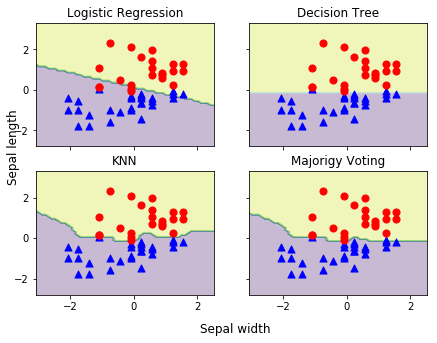

In [43]:
# tuning ensemble classifier
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
from itertools import product #
x_min = X_train_std[:,0].min() -1 
x_max = X_train_std[:,0].max() +1 
y_min = X_train_std[:,1].min() -1
y_max = X_train_std[:,1].max() +1 
xx,yy = np.meshgrid(np.arange(x_min,x_max,0.1),np.arange(y_min,y_max,0.1))
f,axarr = plt.subplots(nrows=2,ncols=2,sharex='col',sharey='row',figsize = (7,5))
for idx,clf,tt in zip(product([0,1],[0,1]), all_clf,clf_labels):
    clf.fit(X_train_std,y_train)
    Z = clf.predict(np.c_[xx.ravel(),yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx[0],idx[1]].contourf(xx,yy,Z,alpha = 0.3)
    axarr[idx[0],idx[1]].scatter(X_train_std[y_train==0,0],
                                X_train_std[y_train==0,1],
                                c = 'blue',marker = '^',s = 50)
    axarr[idx[0],idx[1]].scatter(X_train_std[y_train==1,0],
                                X_train_std[y_train==1,1],
                                c = 'red',marker = 'o',s = 50)
    axarr[idx[0],idx[1]].set_title(tt)
plt.text(-3.5,-4.5,s = 'Sepal width',ha = 'center', va = 'center', fontsize = 12)
plt.text(-10.5,4.5,s = "Sepal length", ha = 'center', va = 'center', fontsize = 12, rotation = 90)

In [45]:
mv_clf.get_params()

{'pipeline-1': Pipeline(memory=None,
      steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ['clf', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False)]]),
 'decisiontreeclassifier': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=0,
             splitter='best'),
 'pipeline-2': Pipeline(memory=None,
      steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ['clf', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=No

In [46]:
from sklearn.grid_search import GridSearchCV
params = {'decisiontreeclassifier__max_depth':[1,2],
         'pipeline-1__clf__C':[0.001,0.1,100]}
grid = GridSearchCV(estimator = mv_clf,param_grid = params,cv = 10,scoring = 'roc_auc')
grid.fit(X_train,y_train)


GridSearchCV(cv=10, error_score='raise',
       estimator=MajorityVoteClassifier(classifiers=[Pipeline(memory=None,
     steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ['clf', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', ra...ski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')]])],
            vote='classlabel', weights=None),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'decisiontreeclassifier__max_depth': [1, 2], 'pipeline-1__clf__C': [0.001, 0.1, 100]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [49]:
grid.grid_scores_

[mean: 0.96667, std: 0.10000, params: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001},
 mean: 0.96667, std: 0.10000, params: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1},
 mean: 1.00000, std: 0.00000, params: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100},
 mean: 0.96667, std: 0.10000, params: {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001},
 mean: 0.96667, std: 0.10000, params: {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1},
 mean: 1.00000, std: 0.00000, params: {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100}]

In [61]:
for params,mean_score,scores in grid.grid_scores_:
    print("{} +/- {} and {}".format(round(mean_score,2),round(scores.std()/2,2),params))

0.97 +/- 0.05 and {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.97 +/- 0.05 and {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
1.0 +/- 0.0 and {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100}
0.97 +/- 0.05 and {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.97 +/- 0.05 and {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
1.0 +/- 0.0 and {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100}


In [62]:
grid.best_score_

1.0

BOOK: Stacked generalization Neural networks

## 5. Bagging

### 5.1 Data Preprocessing

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
df_wine = pd.read_csv('https://gist.githubusercontent.com/tijptjik/9408623/raw/b237fa5848349a14a14e5d4107dc7897c21951f5/wine.csv')
df_wine.columns = ['Class label','Alcohol','Malic acid','Ash','Alcalinity of ash','Magnesium','Total phenols','Flavanoids',
                   'Nonflavanoid phenols','Proanthocyanins','Color intensity','Hue','OD280/OD315 of diluted wines','Proline']
df_wine = df_wine[df_wine['Class label']!=1]
X = df_wine[['Alcohol','Hue']].values
y = df_wine['Class label'].values

In [88]:
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.4,random_state = 1)

### 5.2 BaggingClassifier

In [73]:
from sklearn.ensemble import BaggingClassifier
tree = DecisionTreeClassifier(criterion='entropy',max_depth= None)
bag = BaggingClassifier(base_estimator = tree,n_estimators = 500, max_samples = 1.0, max_features = 1.0, bootstrap = True,
                       bootstrap_features = False, n_jobs = 1,random_state = 1)


In [74]:
from sklearn.metrics import accuracy_score
tree = tree.fit(X_train,y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
print(accuracy_score(y_train,y_train_pred))
print(accuracy_score(y_test,y_test_pred))

1.0
0.8541666666666666


In [75]:
from sklearn.metrics import accuracy_score
bag = bag.fit(X_train,y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)
print(accuracy_score(y_train,y_train_pred))
print(accuracy_score(y_test,y_test_pred))

1.0
0.8958333333333334


Text(10.2,-1.2,'Hue')

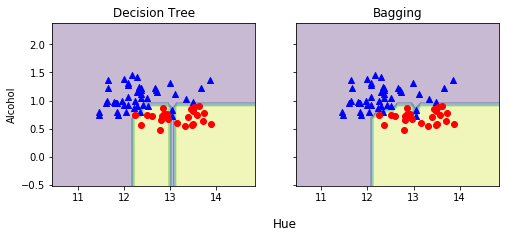

In [82]:
x_min = X_train[:,0].min() -1
x_max = X_train[:,0].max() +1
y_min = X_train[:,1].min() -1
y_max = X_train[:,1].max() +1
xx,yy = np.meshgrid(np.arange(x_min,x_max,0.1),np.arange(y_min,y_max,0.1))
f,axarr = plt.subplots(nrows=1,ncols=2,sharex='col',sharey='row',figsize = (8,3))
for idx,clf,tt in zip([0,1],[tree,bag],['Decision Tree','Bagging']):
    clf.fit(X_train,y_train)
    Z = clf.predict(np.c_[xx.ravel(),yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx].contourf(xx,yy,Z,alpha = 0.3)
    axarr[idx].scatter(X_train[y_train == 0,0],
                      X_train[y_train == 0,1],
                      c = 'blue',marker = '^')
    axarr[idx].scatter(X_train[y_train == 1,0],
                      X_train[y_train == 1,1],
                      c = 'red',marker = 'o')
    axarr[idx].set_title(tt)
axarr[0].set_ylabel("Alcohol")
plt.text(10.2,-1.2,s = 'Hue',ha = 'center',va = 'center',fontsize = 12)


Bagging can avoid overfitting.  
effective to reduce the variance of a model  
ineffective in reducing bias  
That's why we choose unpruned decision tree.  

## 6. Adaptive boosting

In [92]:
from sklearn.ensemble import AdaBoostClassifier
tree = DecisionTreeClassifier(criterion='entropy',max_depth= None)
ada = AdaBoostClassifier(base_estimator = tree,n_estimators = 500, learning_rate = 0.1,random_state = 0)
from sklearn.metrics import accuracy_score
tree = tree.fit(X_train,y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
print(accuracy_score(y_train,y_train_pred))
print(accuracy_score(y_test,y_test_pred))


1.0
0.8333333333333334


In [93]:

ada = ada.fit(X_train,y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)
print(accuracy_score(y_train,y_train_pred))
print(accuracy_score(y_test,y_test_pred))

1.0
0.8333333333333334


Text(10.2,-1.2,'Hue')

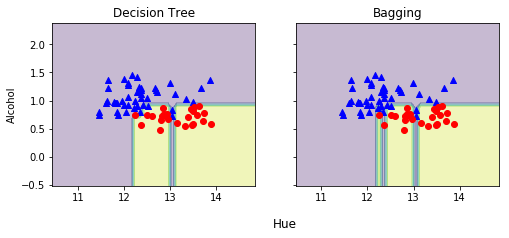

In [94]:
x_min = X_train[:,0].min() -1
x_max = X_train[:,0].max() +1
y_min = X_train[:,1].min() -1
y_max = X_train[:,1].max() +1
xx,yy = np.meshgrid(np.arange(x_min,x_max,0.1),np.arange(y_min,y_max,0.1))
f,axarr = plt.subplots(nrows=1,ncols=2,sharex='col',sharey='row',figsize = (8,3))
for idx,clf,tt in zip([0,1],[tree,ada],['Decision Tree','Bagging']):
    clf.fit(X_train,y_train)
    Z = clf.predict(np.c_[xx.ravel(),yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx].contourf(xx,yy,Z,alpha = 0.3)
    axarr[idx].scatter(X_train[y_train == 0,0],
                      X_train[y_train == 0,1],
                      c = 'blue',marker = '^')
    axarr[idx].scatter(X_train[y_train == 1,0],
                      X_train[y_train == 1,1],
                      c = 'red',marker = 'o')
    axarr[idx].set_title(tt)
axarr[0].set_ylabel("Alcohol")
plt.text(10.2,-1.2,s = 'Hue',ha = 'center',va = 'center',fontsize = 12)


## 7. Summary

### Bagging: A useful technique to reduce the variance of a model  
### AdaBoost: based on weak leaners that subequently learn from mistake

## 8. Reference

Bagging Prediction L.Breiman  
BOOK: The strength of weak learnability. Machine Learning. Robert Schapire  
BOOK: Experiments with a New Boosting Algorithm.  
BOOK: Bias,Variance and Arcing Classifiers  
BOOK: An Improvement of Adaboost to Avoid Overfitting.